## <span style="color:#0b486b">Deep Neural Networks (DNN) </span>

You are going to work with the **EMNIST** dataset for *image recognition task*. This dataset can be installed with the command <kbd>pip install emnist</kbd>. It has the exact same format as MNIST (grayscale images of 28 × 28 pixels), but the images represent handwritten letters rather than handwritten digits, so the problem is more challenging than MNIST.

### <span style="color:#0b486b">Question 2.1: Load the EMNIST datasets and process data</span> 


<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

We first use functions in the package **emnist**, namely <kbd>extract_training_samples</kbd> and <kbd>extract_test_samples</kbd>, to load the training and testing sets. We also want to encode labels using an ordinal encoding scheme.

In [1]:
# pip install emnist

In [2]:
import numpy as np
from emnist import extract_training_samples, extract_test_samples
from sklearn.preprocessing import LabelEncoder

In [3]:
X_train_raw, y_train_raw = extract_training_samples("letters")
X_test_raw, y_test_raw = extract_test_samples("letters")
print(X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape)

(124800, 28, 28) (124800,) (20800, 28, 28) (20800,)


In [4]:
le = LabelEncoder()
le.fit(y_train_raw.ravel())
y_train_full = le.transform(y_train_raw).ravel()
y_test = le.transform(y_test_raw).ravel()

class_ids = np.unique(y_train_full)
n_classes = len(class_ids)
print(class_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


The shape of training and testing data are $(num\_train, 28, 28)$ and $(num\_test, 28, 28)$, where $num\_train$ and $num\_test$ are number of training and testing images respectively. We next convert them to arrays of vectors which have shape $(num\_train, 784)$ and $(num\_test, 784)$.

In [5]:
num_train = X_train_raw.shape[0]
num_test = X_test_raw.shape[0]
X_train_full = X_train_raw.reshape(num_train, -1)   # -1 --> calculates the size for the unspecified dimension automatically 
X_test = X_test_raw.reshape(num_test, -1)
print(X_train_full.shape, y_train_full.shape)
print(X_test.shape, y_test.shape)

(124800, 784) (124800,)
(20800, 784) (20800,)


### <span style="color:#0b486b">Question 2.2: Split data into training, validation, and testing datasets</span>

<div style="text-align: right"> <span style="color:red">[2 points]</span> </div>

You need to write the code to address the following requirements:
- Use $10 \%$ of `X_train_full`, `y_train_full` for validation and the rest of `X_train_full`, `y_train_full` for training. This splits `X_train_full` and `y_train_full` into `X_train`, `y_train` ($90 \%$) and `X_val`, `y_val` ($10 \%$).
- Finally, scale the pixels of `X_train`, `X_val`, and `X_test` to $[0,1]$) (i.e., $X = X/255.0$).

You have now the separate training, validation, and testing sets for training your model.



In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size = 0.9, random_state = 42)
X_train, X_val, X_test = X_train/255.0, X_val/255.0, X_test/255.0

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)   
print(X_test.shape, y_test.shape)

print(X_train.min(), X_train.max(), X_val.min(), X_val.max(), X_test.min(), X_test.max())

(112320, 784) (112320,)
(12480, 784) (12480,)
(20800, 784) (20800,)
0.0 1.0 0.0 1.0 0.0 1.0


### <span style="color:#0b486b">Question 2.3: Visualize some images in the training set with labels</span>

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

You are required to write the code to **randomly** show $36$ images in X_train_full_img (which is an array of images) with labels as in the following figure.

<img src="Figures/emnist_grid.png" width="450" align="center"/>

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import math
def visualize_data(images, categories, images_per_row = 6):
    class_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    n_images = len(images)   # 36
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')   # colour within the borders
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap=plt.get_cmap('gray_r'))   # colour of the images
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

In [9]:
X_train_full_img = X_train_raw
y_train_full_img = y_train_full

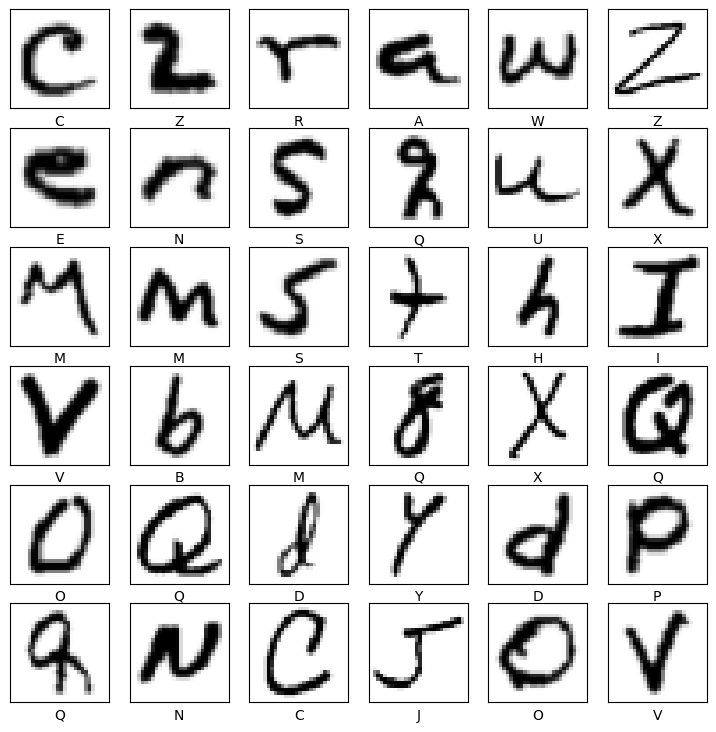

In [10]:
# Randomly show 36 images

import random

X_train_random_img = []
y_train_random_img = []

lower_bound = 0
upper_bound = len(X_train_full_img)
valid_choices = list(range(upper_bound+1))

for _ in range(36):
    i = random.randint(lower_bound, upper_bound)
    valid_choices.pop(i)
    upper_bound -= 1
    X_train_random_img.append(X_train_full_img[i])
    y_train_random_img.append(y_train_full_img[i])

# convert into numpy
X_train_random_img = np.array(X_train_random_img)
y_train_random_img = np.array(y_train_random_img)
        
visualize_data(X_train_random_img, y_train_random_img)

### <span style="color:#0b486b">Question 2.4: Write code for the feed-forward neural net using TF 2.x</span>

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

We now develop a feed-forward neural network with the architecture $784 \rightarrow 20(ReLU) \rightarrow 40(ReLU) \rightarrow 26(softmax)$. You can choose your own way to implement your network and an optimizer of interest. You should train model in $20$ epochs and evaluate the trained model on the test set.

In [11]:
import tensorflow as tf
random_seed = 3181
tf.random.set_seed(random_seed)

<u>Construction Phase</u>

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
dnn_model = Sequential()
dnn_model.add(Dense(units=20,  input_shape=(784,), activation='relu'))
dnn_model.add(Dense(units=40, activation='relu'))
dnn_model.add(Dense(units=n_classes, activation='softmax'))   # probabilistic value  # n_classes = 26 in this case

In [14]:
dnn_model.build()
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 40)                840       
                                                                 
 dense_2 (Dense)             (None, 26)                1066      
                                                                 
Total params: 17,606
Trainable params: 17,606
Non-trainable params: 0
_________________________________________________________________


<u>Execution and Evaluation Phase</u>

In [15]:
dnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

In [16]:
# Training and Evaluating

from tensorflow import keras
logdir = "tf_logs/part2"

# Init a tensorboard_callback 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Call the fit method, passing the tensorboard_callback 
history = dnn_model.fit(x=X_train, y=y_train, batch_size=32, 
                        epochs=20, 
                        validation_data=(X_val, y_val), 
                        callbacks=[tensorboard_callback])

Epoch 1/20
3510/3510 [==============================] - 8s 2ms/step - loss: 1.1527 - accuracy: 0.6637 - val_loss: 0.8558 - val_accuracy: 0.7476
Epoch 2/20
3510/3510 [==============================] - 7s 2ms/step - loss: 0.7629 - accuracy: 0.7738 - val_loss: 0.7168 - val_accuracy: 0.7885
Epoch 3/20
3510/3510 [==============================] - 7s 2ms/step - loss: 0.6606 - accuracy: 0.8027 - val_loss: 0.6507 - val_accuracy: 0.8072
Epoch 4/20
3510/3510 [==============================] - 8s 2ms/step - loss: 0.6133 - accuracy: 0.8149 - val_loss: 0.6108 - val_accuracy: 0.8182
Epoch 5/20
3510/3510 [==============================] - 7s 2ms/step - loss: 0.5817 - accuracy: 0.8240 - val_loss: 0.5860 - val_accuracy: 0.8222
Epoch 6/20
3510/3510 [==============================] - 7s 2ms/step - loss: 0.5606 - accuracy: 0.8291 - val_loss: 0.5830 - val_accuracy: 0.8232
Epoch 7/20
3510/3510 [==============================] - 7s 2ms/step - loss: 0.5438 - accuracy: 0.8344 - val_loss: 0.5532 - val_accuracy:

In [17]:
dnn_model.evaluate(X_test, y_test)  #return loss and accuracy

650/650 [==============================] - 1s 2ms/step - loss: 0.5174 - accuracy: 0.8492


[0.5173986554145813, 0.8492307662963867]

The loss value for the trained model is $0.5173986554145813$ and the accuracy is $0.8492307662963867$ (which is $84.92\%$), when evaluated on the test set.

### <span style="color:#0b486b">Question 2.5: Tuning hyper-parameters with grid search</span>
<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

Assume that you need to tune the number of neurons on the first and second hidden layers $n_1 \in \{20, 40\}$, $n_2 \in \{20, 40\}$  and the used activation function  $act \in \{sigmoid, tanh, relu\}$. The network has the architecture pattern $784 \rightarrow n_1 (act) \rightarrow n_2(act) \rightarrow 10(softmax)$ where $n_1, n_2$, and $act$ are in their grides. Write the code to tune the hyper-parameters $n_1, n_2$, and $act$. Note that you can freely choose the optimizer and learning rate of interest for this task.

In [18]:
neurons1 = [20,40]
neurons2 = [20,40]
act = ['sigmoid','tanh','relu']

In [19]:
def compile_seq_model(n1, n2, act):
    dnn_model = Sequential()
    dnn_model.add(Dense(units=n1,  input_shape=(784,), activation=act))
    dnn_model.add(Dense(units=n2, activation=act))
    dnn_model.add(Dense(units=n_classes, activation='softmax'))
    dnn_model.build()
    dnn_model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
    return dnn_model

In [20]:
best_acc = 0
best_model = None
best_n1 = None
best_n2 = None
best_act = None

for n1 in neurons1:
    for n2 in neurons2:
        for i in range(len(act)):
            dnn_model = compile_seq_model(n1, n2, act[i])
            print("*Evaluating with n1 = {}, n2 = {}, act = {}\n".format(n1, n2, act[i]))
            dnn_model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose=0)
            acc = dnn_model.evaluate(X_val, y_val)[1]   # accuracy
            print("The valid accuracy is {}\n".format(acc))
            if acc > best_acc:
                best_acc = acc
                best_model = dnn_model
                best_n1 = n1
                best_n2 = n2
                best_act = act[i]
                
print("The best valid accuracy is {} with n1 = {}, n2 = {}, act = {}".format(best_acc, best_n1, best_n2, best_act))

*Evaluating with n1 = 20, n2 = 20, act = sigmoid

390/390 [==============================] - 1s 1ms/step - loss: 0.7000 - accuracy: 0.7912
The valid accuracy is 0.7911859154701233

*Evaluating with n1 = 20, n2 = 20, act = tanh

390/390 [==============================] - 1s 2ms/step - loss: 0.6782 - accuracy: 0.7973
The valid accuracy is 0.7972756624221802

*Evaluating with n1 = 20, n2 = 20, act = relu

390/390 [==============================] - 1s 2ms/step - loss: 0.5988 - accuracy: 0.8243
The valid accuracy is 0.8242788314819336

*Evaluating with n1 = 20, n2 = 40, act = sigmoid

390/390 [==============================] - 1s 2ms/step - loss: 0.6458 - accuracy: 0.8076
The valid accuracy is 0.8076121807098389

*Evaluating with n1 = 20, n2 = 40, act = tanh

390/390 [==============================] - 1s 2ms/step - loss: 0.5955 - accuracy: 0.8223
The valid accuracy is 0.8222756385803223

*Evaluating with n1 = 20, n2 = 40, act = relu

390/390 [==============================] - 1s 1ms/step - 

<u>Save and Load the Best Model</u>

In [21]:
# Saving the entire model to a directory
best_model.save('models/part2/')

INFO:tensorflow:Assets written to: models/part2/assets


In [22]:
# Loading the best model back 
from tensorflow import keras
best_model = keras.models.load_model('models/part2/')

In [23]:
best_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 40)                31400     
                                                                 
 dense_37 (Dense)            (None, 40)                1640      
                                                                 
 dense_38 (Dense)            (None, 26)                1066      
                                                                 
Total params: 34,106
Trainable params: 34,106
Non-trainable params: 0
_________________________________________________________________


### <span style="color:#0b486b">Question 2.6: Experimenting with the **label smoothing** technique</span>
<div style="text-align: right"> <span style="color:red">[8 points]</span> </div>

Implement the label smoothing technique (i.e., [link for main paper](https://papers.nips.cc/paper/2019/file/f1748d6b0fd9d439f71450117eba2725-Paper.pdf) from Goeff Hinton) by yourself. Note that you cannot use the built-in label-smoothing loss function in TF2.x. Try the label smoothing technique with $\alpha =0.1, 0.15, 0.2$ and report the performances. You need to examine the label smoothing technique with the best architecture obtained in **Question 2.5**.

In [24]:
def label_smoothing(truth_one_hot, alpha):
    LS_truth = ((1 - alpha) * truth_one_hot) + (alpha / n_classes)
    return LS_truth

In [25]:
from sklearn.preprocessing import LabelBinarizer

# convert the labels from integers to vectors, converting the data
# type to floats so we can apply label smoothing

binarizer = LabelBinarizer()

y_train_one_hot = binarizer.fit_transform(y_train)
y_val_one_hot = binarizer.transform(y_val)

y_train_one_hot = y_train_one_hot.astype("float")
y_val_one_hot = y_val_one_hot.astype("float")

In [26]:
def compile_seq_model_LS(n1, n2, act):
    dnn_model = Sequential()
    dnn_model.add(Dense(units=n1,  input_shape=(784,), activation=act))
    dnn_model.add(Dense(units=n2, activation=act))
    dnn_model.add(Dense(units=n_classes, activation='softmax'))
    dnn_model.build()
    dnn_model.compile(optimizer='adam', 
                      loss='categorical_crossentropy',   # supports one-hot encoded vectors
                      metrics=['accuracy'])
    return dnn_model

In [27]:
alpha = [0.1,0.15,0.2]

In [28]:
# Construct the best model obtained in Question 2.5
best_n1 = 40 
best_n2 = 40
best_act = 'relu'
best_model = compile_seq_model_LS(best_n1, best_n2, best_act)

best_acc = 0

for i in range(len(alpha)):
    print("*Evaluating with 𝛼 = {}\n".format(str(alpha[i])))
    y_train_LS = label_smoothing(y_train_one_hot, alpha[i])   # label smoothing for y_train
    best_model.fit(x=X_train, y=y_train_LS, batch_size=32, epochs=20, validation_data=(X_val, y_val_one_hot))
    acc = best_model.evaluate(X_val, y_val_one_hot)[1]   # accuracy
    print("The valid accuracy is {}\n".format(acc))
    if acc > best_acc:
        best_acc = acc
        best_i = i
        
print("The best valid accuracy is {} with 𝛼 = {}".format(best_acc, alpha[best_i]))

*Evaluating with 𝛼 = 0.1

Epoch 1/20
3510/3510 [==============================] - 8s 2ms/step - loss: 1.4836 - accuracy: 0.7176 - val_loss: 0.7701 - val_accuracy: 0.7997
Epoch 2/20
3510/3510 [==============================] - 7s 2ms/step - loss: 1.1998 - accuracy: 0.8206 - val_loss: 0.6457 - val_accuracy: 0.8374
Epoch 3/20
3510/3510 [==============================] - 7s 2ms/step - loss: 1.1307 - accuracy: 0.8457 - val_loss: 0.5994 - val_accuracy: 0.8490
Epoch 4/20
3510/3510 [==============================] - 8s 2ms/step - loss: 1.0956 - accuracy: 0.8564 - val_loss: 0.5871 - val_accuracy: 0.8543
Epoch 5/20
3510/3510 [==============================] - 7s 2ms/step - loss: 1.0741 - accuracy: 0.8640 - val_loss: 0.5614 - val_accuracy: 0.8614
Epoch 6/20
3510/3510 [==============================] - 7s 2ms/step - loss: 1.0602 - accuracy: 0.8681 - val_loss: 0.5585 - val_accuracy: 0.8642
Epoch 7/20
3510/3510 [==============================] - 7s 2ms/step - loss: 1.0482 - accuracy: 0.8718 - val_lo

The $\alpha$ value of $0.2$ used in label smoothing gives the highest valid accuracy among the three $\alpha$ values when the performance of the DNN model is evaluated with the validation data, which is $0.884294867515564$. Also, the $\alpha$ value of $0.15$ results in higher valid accuracy ($0.8794070482254028$) if compared to the valid accuracy obtained from the $\alpha$ value of $0.1$ ($0.8775641322135925$).